In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loan_dt = pd.read_csv("lending-club-loan-data/loan.csv")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_dt.tail()
print (loan_dt.shape)


(887379, 74)


In [4]:
loan_dt.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
887374,36371250,39102635,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,17100.0,NaN,NaN,NaN
887375,36441262,39152692,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,10200.0,NaN,NaN,NaN
887376,36271333,38982739,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,18000.0,NaN,NaN,NaN
887377,36490806,39222577,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,...,NaN,NaN,NaN,NaN,NaN,NaN,27000.0,NaN,NaN,NaN
887378,36271262,38982659,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,41700.0,NaN,NaN,NaN


* NA값을 확인 해 보자


In [5]:
loan_dt.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51457
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                             151
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

### 변수에서 먼저 생각해야 할 문제
* y값: loan_status
* identify feature : 'member_id', 'id'
<br><br>

* seems to main real features: 'loan_amnt', 'funded_amnt',
'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim'
<br> * 'total_pymnt', 'total_pymnt_inv' (이 두개는 비슷 해 보이긴 한데 좀 수치는 다름)
<br><t> * need to cleansing: 'emp_length',
<br><br>
* category feature : 'term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'inq_last_6mths', 'initial_list_status','policy_code','application_type', 
<br><br>
* others: 'emp_title', 'issue_d' (how to transfer real number), 'desc', 'purpose', 'title', 'addr_state', 'last_pymnt_d', 'last_credit_pull_d', 
<br><br>
* looks not need : 'url', 'zip_code', 'next_pymnt_d'(단지 아직 완결이 안난듯?),
'collections_12_mths_ex_med'(거의 값이 0)
<br><br>
* weight?(가중치 혹은 마이너스) : 'delinq_2yrs', 'earliest_cr_line' (신용거래가 오래되면 상환을 잘 할까?), 'mths_since_last_delinq''mths_since_last_record', 'pub_rec', 'out_prncp'(미납된 원금), 'out_prncp_inv'(두개 값은 거의 같아보임),
'total_rec_late_fee'(연체이자니깐), 'recoveries'(부실액인듯?), 'collection_recovery_fee'(추심수수료?), 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 
<br><br>
* NAN값이 많은 변수 : 'annual_inc_joint','dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'

# 1. y 파악

In [6]:
loan_dt_y = loan_dt['loan_status']
loan_dt_y.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

* 지도 학습이기 때문에 current는 사용할 수 없을 것 같다
* 연체로 볼수 있는 경우
<t>
    > charged off: 체납 , 추심으로 넘어가는데 동의 (일반적으로 180일 연체)
<br> 
    > late(31-120 days) : 1~ 4달의 연체
<br> 
    > late(16-30 days) : 1달이내 연체
<br>
    > default : 연체
<br>
    > Does not meet the credit policy. Status:Charged Off : 대출조건 맞지 않지만 회수 안됨
<p>
* 완납 
<br>
    > fully paid
<br>
    > Does not meet the credit policy. Status:Fully Paid : 대출조건 맞지 않아 전액 상환
<br>
<p>
* 기타
<br>
    > Current : 현재 상환진행
<br>
    > Issued : 대출결정
<br>
    > In Grace Period : 상환 유예기간 (거치중인 기간인 듯)


## 분석은 '기타' 상태를 제외하고 진행
 * 완제 : 209,711 건
 * 연체 :  61,176 건
 * Total : 270,887 건
 

In [7]:
loan = loan_dt[loan_dt.loan_status !='Current']



In [8]:
loan = loan [loan_dt.loan_status !='Issued']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [9]:
loan = loan [loan_dt.loan_status !='In Grace Period']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [10]:
loan.loan_status

0                 Fully Paid
1                Charged Off
2                 Fully Paid
3                 Fully Paid
5                 Fully Paid
7                 Fully Paid
8                Charged Off
9                Charged Off
10                Fully Paid
11                Fully Paid
12               Charged Off
13                Fully Paid
14               Charged Off
15                Fully Paid
16                Fully Paid
17                Fully Paid
18                Fully Paid
19                Fully Paid
20                Fully Paid
21               Charged Off
22                Fully Paid
23                Fully Paid
24               Charged Off
25                Fully Paid
26               Charged Off
27               Charged Off
28                Fully Paid
29                Fully Paid
30                Fully Paid
31                Fully Paid
                 ...        
887198            Fully Paid
887202            Fully Paid
887215            Fully Paid
887231    Late

In [11]:
loan.shape
#loan.head()

(270887, 74)

In [12]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# 메모리 정리
del loan_dt,loan_dt_y
gc.collect()

165



import csv
#loan = loan.drop('desc', axis=1)


#path = "lending-club-loan-data/loan_mod.csv"
loan.to_csv("lending-club-loan-data/loan_mod.csv")

In [3]:

#loan = loan.drop('url', axis = 1)
#loan = loan.drop('pur_desc', axis = 1)

loan = pd.read_csv("lending-club-loan-data/loan_mod.csv", encoding='utf-8')
#위의 파일을 csv로 내보낼 거면


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (20,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1-1) y값 분리 & 변환
* 상환 : 0
* 연체 & 부실: 1

In [13]:
# y 값 이진으로 변환  : 상환 = 1 / 연체 = 0 으로 변환
loan = loan.replace(["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"],0) # 상환
loan = loan.replace(['Charged Off','Late (31-120 days)','Late (16-30 days)','Default', 
                         'Does not meet the credit policy. Status:Charged Off'],1) # 연체

In [14]:

loan.loan_status

0         0
1         1
2         0
3         0
5         0
7         0
8         1
9         1
10        0
11        0
12        1
13        0
14        1
15        0
16        0
17        0
18        0
19        0
20        0
21        1
22        0
23        0
24        1
25        0
26        1
27        1
28        0
29        0
30        0
31        0
         ..
887198    0
887202    0
887215    0
887231    1
887248    1
887249    0
887254    1
887258    1
887263    0
887264    0
887268    1
887275    1
887276    1
887279    0
887280    1
887290    1
887303    1
887308    1
887322    1
887330    1
887332    0
887337    1
887345    1
887346    0
887347    0
887351    1
887364    0
887366    0
887369    0
887371    1
Name: loan_status, Length: 270887, dtype: int64

# 2. 양적변수 전처리

In [15]:
col_real = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
            'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal',
            'total_rev_hi_lim','total_pymnt', 'total_pymnt_inv','emp_length', ]
# 19개

In [16]:
loan_col_real = loan[col_real]
loan_col_real.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length
887351,4200.0,4200.0,4200.0,15.99,147.64,48000.0,36.93,13.0,12943.0,63.4,45.0,667.96,358.06,147.64,207975.0,20400.0,1026.02,1026.02,10+ years
887364,10775.0,10775.0,10775.0,6.03,327.95,54000.0,13.22,9.0,10776.0,25.8,21.0,10775.00,296.87,9439.34,24696.0,41700.0,11071.87,11071.87,< 1 year
887366,6225.0,6225.0,6225.0,16.49,220.37,27000.0,18.58,3.0,1756.0,97.6,4.0,6225.00,825.46,4858.17,8357.0,1800.0,7050.46,7050.46,2 years
887369,4000.0,4000.0,4000.0,8.67,126.59,50000.0,12.63,11.0,1700.0,5.6,30.0,4000.00,158.02,3655.51,18979.0,30100.0,4158.02,4158.02,10+ years
887371,10850.0,10850.0,10850.0,19.24,399.04,32000.0,29.44,9.0,6987.0,41.6,20.0,1405.77,990.28,25.00,53777.0,16800.0,2396.05,2396.05,n/a


In [17]:
# 양적변수에서의 NA값
loan_col_real.isnull().sum()

loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
int_rate                0
installment             0
annual_inc              4
dti                     0
open_acc               29
revol_bal               0
revol_util            251
total_acc              29
total_rec_prncp         0
total_rec_int           0
last_pymnt_amnt         0
tot_cur_bal         66623
total_rev_hi_lim    66623
total_pymnt             0
total_pymnt_inv         0
emp_length              0
dtype: int64

## 2-1) emp_length 숫자로 변환

In [18]:
#emp_length값 숫자로 변환 1
loan_col_real['emp_length'].value_counts()


10+ years    81939
2 years      25261
< 1 year     22686
3 years      21873
5 years      19150
1 year       18224
4 years      17295
6 years      15676
7 years      14964
8 years      12692
n/a          10863
9 years      10264
Name: emp_length, dtype: int64

In [19]:
# 정규표현식을 사용하려 값을 변환하려 하였으나 계산 과부하로 replace 함수 사용
# n/a의 값은 무시못할 정도로 많긴 하나 심사당시 재직기간에 대한 점수를 받지 못하였을 것으로 가정하고 0으로 할당
loan['emp_length']= loan['emp_length'].replace({'10+ years':10, '2 years':2, '3 years':3,
                                                                 '5 years':5, '1 year':1, '4 years':4,
                                                                 '6 years':6, '7 years':7, '8 years': 8,
                                                                 '9 years': 9, '< 1 year': 1, 'n/a':0})#._update_inplace(loan_col_real['emp_length'])

In [20]:
loan['emp_length']

0         10
1          1
2         10
3         10
5          3
7          9
8          4
9          1
10         5
11        10
12         1
13         3
14         3
15         1
16         4
17        10
18         1
19         6
20         3
21        10
22        10
23         5
24         1
25         2
26         9
27         2
28        10
29         1
30         7
31         5
          ..
887198    10
887202     1
887215     6
887231     2
887248     4
887249     1
887254     5
887258     5
887263     1
887264    10
887268    10
887275    10
887276    10
887279     5
887280     3
887290     8
887303     9
887308     0
887322     2
887330     5
887332     6
887337     0
887345     3
887346     4
887347    10
887351    10
887364     1
887366     2
887369    10
887371     0
Name: emp_length, Length: 270887, dtype: int64

In [21]:
loan_col_real.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length
887351,4200.0,4200.0,4200.0,15.99,147.64,48000.0,36.93,13.0,12943.0,63.4,45.0,667.96,358.06,147.64,207975.0,20400.0,1026.02,1026.02,10+ years
887364,10775.0,10775.0,10775.0,6.03,327.95,54000.0,13.22,9.0,10776.0,25.8,21.0,10775.00,296.87,9439.34,24696.0,41700.0,11071.87,11071.87,< 1 year
887366,6225.0,6225.0,6225.0,16.49,220.37,27000.0,18.58,3.0,1756.0,97.6,4.0,6225.00,825.46,4858.17,8357.0,1800.0,7050.46,7050.46,2 years
887369,4000.0,4000.0,4000.0,8.67,126.59,50000.0,12.63,11.0,1700.0,5.6,30.0,4000.00,158.02,3655.51,18979.0,30100.0,4158.02,4158.02,10+ years
887371,10850.0,10850.0,10850.0,19.24,399.04,32000.0,29.44,9.0,6987.0,41.6,20.0,1405.77,990.28,25.00,53777.0,16800.0,2396.05,2396.05,n/a


## 2-2) open_acc 
* 신용 거래의 수

In [22]:

loan_col_real.open_acc.value_counts()

9.0     25876
8.0     24713
10.0    24478
11.0    22608
7.0     22406
12.0    19862
6.0     18896
13.0    16651
14.0    13972
5.0     13359
15.0    11304
16.0     9341
4.0      8036
17.0     7392
18.0     6008
19.0     4796
3.0      3806
20.0     3684
21.0     2876
22.0     2233
23.0     1694
2.0      1344
24.0     1342
25.0      982
26.0      691
27.0      570
28.0      378
29.0      294
30.0      242
31.0      177
32.0      169
33.0      127
34.0       98
1.0        88
35.0       67
36.0       57
37.0       51
38.0       35
39.0       28
40.0       23
41.0       18
42.0       15
43.0       12
44.0        8
45.0        8
47.0        8
46.0        7
0.0         6
49.0        4
48.0        3
52.0        3
50.0        3
76.0        2
53.0        2
54.0        1
58.0        1
55.0        1
56.0        1
51.0        1
Name: open_acc, dtype: int64

In [23]:
loan_col_real.open_acc.unique()

array([  3.,   2.,  10.,   9.,   4.,  11.,  14.,  12.,  20.,   8.,   7.,
         6.,  15.,  17.,   5.,  13.,  16.,  30.,  21.,  18.,  19.,  27.,
        23.,  34.,  25.,  22.,  24.,  26.,  32.,  29.,  28.,  33.,  31.,
        39.,  35.,  36.,  38.,  44.,  41.,  42.,   1.,  46.,  37.,  47.,
        nan,  40.,  49.,  45.,  43.,   0.,  48.,  50.,  52.,  76.,  55.,
        58.,  54.,  51.,  53.,  56.])

In [24]:
loan_col_real.open_acc.describe()
#평균값 10으로 NAN
        

count    270858.000000
mean         10.975987
std           4.928649
min           0.000000
25%           7.000000
50%          10.000000
75%          14.000000
max          76.000000
Name: open_acc, dtype: float64

In [25]:
loan.open_acc.fillna(10, inplace = True)
# Nan 값을 평균 값으로 대체 : 결과가 거의 상환

In [26]:
#다시한번 확인
loan.open_acc.isnull().value_counts()

False    270887
Name: open_acc, dtype: int64

## 2- 3) annual_inc
* 연간 소득

In [27]:
loan_col_real.annual_inc.describe()

count    2.708830e+05
mean     7.239960e+04
std      5.834776e+04
min      1.896000e+03
25%      4.500000e+04
50%      6.200000e+04
75%      8.700000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

In [28]:
loan_col_real.loc[loan_col_real.annual_inc.isnull()]
# Nan인 차주는 규정에 맞지 않아 전액 상환임을 알수 있고 재직기간은 1년 미만임을 알 수 있다
# 연간 소득액이 없거나 매우 적음으로 추정하고 최소값으로 대체한다

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length
42449,5000.0,5000.0,3025.0,7.43,155.38,NaN,1.0,NaN,0.0,NaN,NaN,5000.0,593.46,157.31,NaN,NaN,5593.46,3384.01,< 1 year
42450,7000.0,7000.0,3450.0,7.75,218.55,NaN,1.0,NaN,0.0,NaN,NaN,7000.0,867.53,220.03,NaN,NaN,7867.53,3877.59,< 1 year
42480,6700.0,6700.0,6700.0,7.75,209.18,NaN,1.0,NaN,0.0,NaN,NaN,6700.0,830.42,209.89,NaN,NaN,7530.42,7530.42,< 1 year
42533,6500.0,6500.0,0.0,8.38,204.84,NaN,4.0,NaN,0.0,NaN,NaN,6500.0,873.83,205.32,NaN,NaN,7373.83,0.00,< 1 year


In [29]:
loan.annual_inc.fillna(loan_col_real.annual_inc.min(), inplace = True)

In [30]:
loan.annual_inc.isnull().value_counts()
# Nan 값이 없어짐을 확인함

False    270887
Name: annual_inc, dtype: int64

## 2-4) revol_util  
* Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* 한도대출 소진율 또는 현재 이용가능한 모든 한도 대출 중 차주가 사용하고 있는 금액


count    270636.000000
mean         54.524092
std          24.768499
min           0.000000
25%          36.500000
50%          56.000000
75%          74.100000
max         892.300000
Name: revol_util, dtype: float64
most frequently used value: 0    0.0
dtype: float64


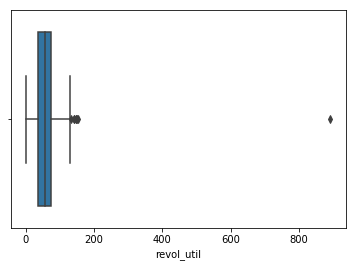

In [31]:
print (loan_col_real.revol_util.describe())
print ("most frequently used value: {}".format(loan_col_real.revol_util.mode()))

X = loan_col_real.loc[loan_col_real['revol_util'].notnull()]
X = X.revol_util.astype(int)


sns.boxplot(X)
plt.show()

In [54]:
# 평균이 올라간 것은 max 값의 영향이 큰것으로 간주되어 결손값은 최빈값인 0으로 채운다
loan.revol_util.fillna(0, inplace = True)

print (loan.revol_util.isnull().value_counts())

print (loan.revol_util.isnull().count())

False    270887
Name: revol_util, dtype: int64
270887


## 2-5) total_acc 
* 현재 차주가 사용하고 있는 신용 한도

In [33]:
loan_col_real.total_acc.isnull().value_counts()

False    270858
True         29
Name: total_acc, dtype: int64

In [34]:
# 5-1)Nan 인 차주의 대략적인 상테
loan_col_real.sort_values('total_acc').tail(30)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length
239772,35000.0,35000.0,35000.0,8.67,1107.63,189000.0,6.63,40.0,39065.0,44.4,150.0,35000.00,2769.97,25602.90,44978.0,88000.0,37769.97,37769.97,10+ years
42449,5000.0,5000.0,3025.0,7.43,155.38,NaN,1.00,NaN,0.0,NaN,NaN,5000.00,593.46,157.31,NaN,NaN,5593.46,3384.01,< 1 year
42450,7000.0,7000.0,3450.0,7.75,218.55,NaN,1.00,NaN,0.0,NaN,NaN,7000.00,867.53,220.03,NaN,NaN,7867.53,3877.59,< 1 year
42459,4350.0,4350.0,825.0,8.07,136.45,120000.0,4.00,NaN,0.0,NaN,NaN,4350.00,561.68,139.93,NaN,NaN,4911.68,931.41,< 1 year
42472,3900.0,3900.0,2025.0,9.33,124.62,98000.0,10.00,NaN,0.0,NaN,NaN,3900.00,585.99,126.06,NaN,NaN,4485.99,2329.19,< 1 year
42480,6700.0,6700.0,6700.0,7.75,209.18,NaN,1.00,NaN,0.0,NaN,NaN,6700.00,830.42,209.89,NaN,NaN,7530.42,7530.42,< 1 year
42483,3200.0,3200.0,2000.0,9.96,103.20,150000.0,10.00,NaN,0.0,NaN,NaN,3200.00,390.53,1733.32,NaN,NaN,3590.53,2244.09,< 1 year
42494,7200.0,5075.0,350.0,10.28,164.42,95000.0,10.00,NaN,0.0,NaN,NaN,5075.00,843.33,168.44,NaN,NaN,5918.33,407.83,< 1 year
42509,1900.0,1900.0,900.0,9.64,61.00,100000.0,10.00,NaN,0.0,NaN,NaN,1900.00,99.12,0.00,NaN,NaN,1999.12,946.95,1 year
42514,1200.0,1200.0,500.0,9.01,38.17,36000.0,3.27,NaN,0.0,NaN,NaN,1200.00,173.88,39.05,NaN,NaN,1373.88,572.45,< 1 year


In [35]:
# 5-2) dti 요약 
print (loan_col_real.dti.describe())

count    270887.000000
mean         16.698684
std           7.861082
min           0.000000
25%          10.850000
50%          16.360000
75%          22.190000
max          57.140000
Name: dti, dtype: float64


In [36]:
# 5-3) 이자율 요약
loan_col_real.int_rate.describe()

count    270887.000000
mean         13.891907
std           4.413615
min           5.320000
25%          10.990000
50%          13.670000
75%          16.780000
max          28.990000
Name: int_rate, dtype: float64

In [37]:
# Nan인 차주들의 dti와 이자율이 평균보다 낮은 것을 확인하고 현재 사용하고 있는 신용 한도는 없는 것으로 추정, 0으로 대체한다
# 기존 record에도 따로 0 값이 없는 것을 확인 할 수 있다
loan_col_real.total_acc.unique()

array([   9.,    4.,   10.,   37.,   12.,   13.,    3.,   23.,   34.,
         11.,   29.,   28.,   42.,   14.,   22.,   38.,   21.,   17.,
          7.,   31.,   44.,   26.,   16.,    6.,   18.,   27.,   25.,
         40.,   35.,   24.,    8.,   20.,   15.,   19.,   36.,   51.,
         32.,   30.,   33.,   46.,    5.,   61.,   56.,   50.,   41.,
         79.,   43.,   47.,   53.,   45.,   60.,   55.,   39.,   52.,
         58.,   54.,   57.,   49.,   63.,   48.,   59.,   62.,   77.,
         87.,   75.,   72.,   64.,   67.,   78.,   76.,   74.,   66.,
         81.,   90.,   80.,   71.,   69.,   73.,   70.,   68.,   65.,
          2.,    1.,   nan,   83.,   88.,   82.,   91.,   99.,   92.,
        150.,   84.,   95.,   85.,   98.,   93.,   89.,  100.,  102.,
        116.,  118.,   94.,   86.,  104.,   96.,  111.,  101.,  110.,   97.])

In [38]:
loan.total_acc.fillna(0, inplace = True)
loan.total_acc.isnull().value_counts()
# 처리 완료

False    270887
Name: total_acc, dtype: int64

## 2-6) tot_cur_bal
* 모든 계정의 총 현재 잔액 (현재 받고 있는 대출)

In [39]:
loan_col_real.tot_cur_bal.describe()

count    2.042640e+05
mean     1.370553e+05
std      1.514555e+05
min      0.000000e+00
25%      2.831175e+04
50%      7.898300e+04
75%      2.062598e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [40]:
loan_col_real.tot_cur_bal.value_counts()

0.0         53
25341.0     10
25443.0     10
15886.0      9
13530.0      9
29288.0      9
30652.0      9
30491.0      9
21944.0      9
4875.0       9
28674.0      9
15043.0      9
19376.0      9
26201.0      8
19998.0      8
19584.0      8
16072.0      8
13818.0      8
18876.0      8
12022.0      8
31743.0      8
13721.0      8
26302.0      8
11329.0      8
13076.0      8
22060.0      8
16709.0      8
25103.0      8
13226.0      8
18311.0      8
            ..
408527.0     1
204225.0     1
125938.0     1
408449.0     1
4627.0       1
30908.0      1
204190.0     1
39381.0      1
408383.0     1
408389.0     1
204199.0     1
204201.0     1
48578.0      1
408405.0     1
70462.0      1
51051.0      1
341044.0     1
457728.0     1
204206.0     1
204207.0     1
25526.0      1
408419.0     1
68730.0      1
204214.0     1
512952.0     1
139200.0     1
102109.0     1
204220.0     1
457756.0     1
9970.0       1
Name: tot_cur_bal, Length: 141932, dtype: int64

In [41]:
#  해당 변수가 영향이 큰지 확인 하기 위해 y 값과 합한다.
loan_check = pd.concat([loan_col_real, loan.loan_status], axis =1)
loan_check.sort_values('tot_cur_bal').tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length,loan_status
230651,12000.0,12000.0,11975.0,7.90,375.49,42000.0,9.83,9.0,14378.0,52.3,14.0,12000.00,1022.07,7397.03,NaN,NaN,13022.070000,12994.94,3 years,0
230652,20500.0,20500.0,20500.0,16.77,728.54,60000.0,16.40,10.0,15417.0,58.4,20.0,20500.00,5673.30,10.21,NaN,NaN,26173.301128,26173.30,7 years,0
230653,15000.0,15000.0,15000.0,15.27,521.97,57600.0,8.35,18.0,8897.0,33.1,30.0,15000.00,3783.86,541.95,NaN,NaN,18783.859440,18783.86,3 years,0
230654,35000.0,35000.0,35000.0,15.96,1229.81,160000.0,4.90,9.0,23665.0,62.4,17.0,35000.00,9267.53,1244.72,NaN,NaN,44267.531697,44267.53,3 years,0
230655,12000.0,12000.0,12000.0,16.29,423.61,35000.0,12.93,14.0,15006.0,93.2,27.0,1063.61,629.79,423.61,NaN,NaN,2075.640000,2075.64,n/a,1


In [42]:
loan_check_1 = loan_check.sort_values('tot_cur_bal')[-66622:]
# na 값을 가지고 있는 차주들의 특성
loan_check_1.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,loan_status
count,66622.000000,66622.000000,66622.000000,66622.000000,66622.000000,6.661800e+04,66622.00000,66593.000000,6.662200e+04,66502.000000,66593.000000,66622.000000,66622.000000,66622.000000,0.0,0.0,66622.000000,66622.000000,66622.00000
mean,11605.237009,11442.534373,11002.068816,12.401450,353.691821,6.849955e+04,14.27404,9.727374,1.418632e+04,51.992543,22.382893,10064.572979,2181.040482,3013.632038,NaN,NaN,12366.535195,11914.601618,0.16430
std,7567.393886,7431.103849,7463.237915,3.943413,227.605360,5.714291e+04,7.03372,4.499181,1.912002e+04,27.410282,11.341556,7318.292335,2379.890117,4868.373115,NaN,NaN,9044.732877,9043.598820,0.37055
min,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.00000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.00000
25%,6000.000000,6000.000000,5325.000000,9.320000,183.000000,4.066125e+04,8.96000,6.000000,4.573000e+03,30.400000,14.000000,4800.000000,704.387500,247.940000,NaN,NaN,5727.257500,5367.380000,0.00000
50%,10000.000000,10000.000000,9750.000000,12.210000,311.110000,5.880000e+04,14.30000,9.000000,9.775500e+03,54.200000,21.000000,8400.000000,1402.795000,629.250000,NaN,NaN,10311.905000,9841.390000,0.00000
75%,15000.000000,15000.000000,15000.000000,14.910000,471.195000,8.200000e+04,19.59000,12.000000,1.764400e+04,74.700000,29.000000,14000.000000,2735.542500,3806.450000,NaN,NaN,16673.996389,16160.402500,0.00000
max,35000.000000,35000.000000,35000.000000,24.890000,1388.450000,6.000000e+06,34.99000,49.000000,1.207359e+06,119.000000,99.000000,35000.030000,22777.580000,36115.200000,NaN,NaN,57777.579870,57777.580000,1.00000


In [43]:
loan_check_1.tot_cur_bal.unique() # 

array([ nan])

In [56]:
# na를 가지고 있지 않은 차주들의 사분위수
loan_check_2= loan_check.sort_values('tot_cur_bal')[:-66623]
loan_check_2.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,loan_status
count,204264.000000,204264.000000,204264.000000,204264.000000,204264.000000,2.042640e+05,204264.000000,204264.000000,2.042640e+05,204133.000000,204264.000000,204264.000000,204264.000000,204264.000000,2.042640e+05,2.042640e+05,204264.000000,204264.000000,204264.000000
mean,14288.320262,14288.265186,14281.334561,14.378045,441.021846,7.367179e+04,17.489444,11.383092,1.567519e+04,55.348672,25.883704,11347.776745,1906.001304,7079.209502,1.370553e+05,2.951796e+04,13415.024181,13408.236212,0.245907
std,8243.296032,8243.214494,8239.699781,4.449817,247.380041,5.867951e+04,7.954445,4.993746,1.994169e+04,23.786682,11.811411,8612.148750,1992.628448,7635.337417,1.514555e+05,2.952449e+04,9575.826716,9571.222150,0.430625
min,1000.000000,1000.000000,950.000000,5.320000,27.850000,3.000000e+03,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,8000.000000,8000.000000,8000.000000,11.140000,264.190000,4.500000e+04,11.520000,8.000000,6.225000e+03,38.100000,17.000000,4500.000000,615.802500,570.840000,2.831175e+04,1.320000e+04,6074.756534,6073.697500,0.000000
50%,12000.000000,12000.000000,12000.000000,14.090000,386.720000,6.400000e+04,17.080000,11.000000,1.127400e+04,56.500000,24.000000,10000.000000,1302.120000,4774.110000,7.898300e+04,2.210000e+04,11258.370060,11252.455000,0.000000
75%,20000.000000,20000.000000,19925.000000,17.270000,575.500000,8.900000e+04,23.170000,14.000000,1.953500e+04,73.900000,33.000000,16000.000000,2453.722500,11027.152500,2.062598e+05,3.660000e+04,18590.166859,18581.965000,0.000000
max,35000.000000,35000.000000,35000.000000,28.990000,1424.570000,8.706582e+06,57.140000,76.000000,1.746716e+06,892.300000,150.000000,35000.000000,21087.910000,36475.590000,8.000078e+06,2.013133e+06,56087.909922,56047.850000,1.000000


In [57]:
loan_check_2.isnull().sum()


loan_amnt             0
funded_amnt           0
funded_amnt_inv       0
int_rate              0
installment           0
annual_inc            0
dti                   0
open_acc              0
revol_bal             0
revol_util          131
total_acc             0
total_rec_prncp       0
total_rec_int         0
last_pymnt_amnt       0
tot_cur_bal           0
total_rev_hi_lim      0
total_pymnt           0
total_pymnt_inv       0
emp_length            0
loan_status           0
dtype: int64

In [58]:
loan_check_2.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,total_pymnt,total_pymnt_inv,emp_length,loan_status
178261,35000.0,35000.0,34975.0,11.14,1148.18,400000.0,33.48,28.0,1743266.0,29.5,59.0,35000.0,951.80,33656.70,3471522.0,2013133.0,35951.800000,35926.12,10+ years,0
232164,18700.0,18700.0,18700.0,12.99,629.99,200000.0,21.28,10.0,220106.0,90.8,24.0,18700.0,979.03,12186.06,3610743.0,225000.0,19679.030000,19679.03,< 1 year,0
677893,35000.0,35000.0,35000.0,10.99,760.82,400000.0,13.49,15.0,555673.0,63.2,27.0,35000.0,520.46,35563.20,3652389.0,632200.0,35520.460000,35520.46,10+ years,0
177927,35000.0,35000.0,35000.0,15.80,1227.05,800000.0,4.12,12.0,54511.0,87.4,14.0,35000.0,7134.90,18835.39,4772549.0,62404.0,42134.904511,42134.90,2 years,0
180080,35000.0,35000.0,35000.0,15.31,1218.61,5000000.0,2.36,13.0,975800.0,0.0,36.0,35000.0,8114.63,58.03,8000078.0,988000.0,43114.630000,43114.63,10+ years,0


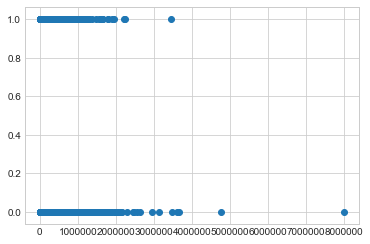

In [59]:
import seaborn as sns

sns.set_style("whitegrid", )
X = loan_check['tot_cur_bal']
y = loan_check['loan_status']
plt.scatter(X, y)
plt.show()

In [60]:
# tot_cur_bal : Total current balance of all accounts
# Lending Club이외의 계정의 대출도 포함되는 것 같다. 
#타사의 정보를 가져올 수 없는 값으로 여겨저 0으로 채운다
loan['tot_cur_bal'] = loan.tot_cur_bal.fillna(0)

In [62]:

gc.collect()

16501

## 2-7)  total_rev_hi_lim
* Total revolving high credit/credit limit
* 높은 신용의 한도대출 limit

In [63]:
loan_col_real['total_rev_hi_lim'].isnull().value_counts()

False    204264
True      66623
Name: total_rev_hi_lim, dtype: int64

count    2.042640e+05
mean     2.951796e+04
std      2.952449e+04
min      0.000000e+00
25%      1.320000e+04
50%      2.210000e+04
75%      3.660000e+04
max      2.013133e+06
Name: total_rev_hi_lim, dtype: float64


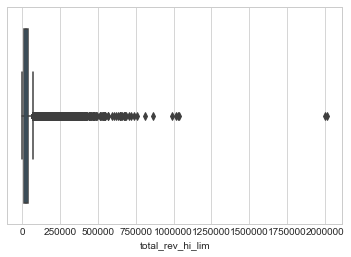

In [64]:
print (loan_col_real.total_rev_hi_lim.describe())

sns.boxplot(loan_col_real.total_rev_hi_lim)
plt.show()

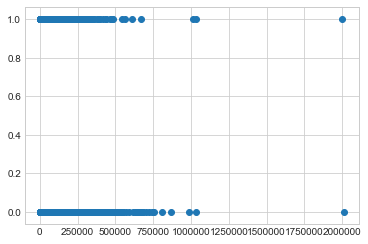

In [65]:
import seaborn as sns
sns.set_style("whitegrid", )
X = loan_check['total_rev_hi_lim']
y = loan_check['loan_status']
plt.scatter(X, y)
plt.show()

In [66]:
# 결손값은 0으로 채운다
loan['total_rev_hi_lim'] = loan.total_rev_hi_lim.fillna(0)
print (loan.total_rev_hi_lim.isnull().value_counts())

False    270887
Name: total_rev_hi_lim, dtype: int64


# 3. 기타 변수들의 결손 값 처리

In [67]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [68]:
col_real = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
            'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal',
            'total_rev_hi_lim','total_pymnt', 'total_pymnt_inv','emp_length', ]

etc = ['term', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
        'inq_fi', 'total_cu_tl', 'inq_last_12m']

#위에서 처리한 col 분류 이외의 변수의 nan확인

In [69]:
loan_check= loan[etc]

In [71]:
loan_check.isnull().sum()

term                                0
grade                               0
sub_grade                           0
emp_title                       15116
emp_length                          0
home_ownership                      0
verification_status                 0
issue_d                             0
pymnt_plan                          0
purpose                             0
title                              14
zip_code                            0
addr_state                          0
delinq_2yrs                        29
earliest_cr_line                   29
inq_last_6mths                     29
mths_since_last_delinq         149189
mths_since_last_record         235810
open_acc                            0
pub_rec                            29
revol_bal                           0
total_acc                           0
initial_list_status                 0
out_prncp                           0
out_prncp_inv                       0
total_rec_late_fee                  0
recoveries  

## 3-1) 의미없는 변수들은 nan값은 0 으로처리

### (1) Emp_title 
* 직업설명

In [72]:

print(loan_check['emp_title'].isnull().value_counts())

loan.emp_title.fillna(0, inplace = True)
print (loan.emp_title.isnull().value_counts())

False    255771
True      15116
Name: emp_title, dtype: int64
False    270887
Name: emp_title, dtype: int64


### (2) title 
* 차주가 기재한 대출 이름

In [73]:

print(loan_check['title'].isnull().value_counts())

loan.title.fillna(0, inplace = True)
print (loan.title.isnull().value_counts())

False    270873
True         14
Name: title, dtype: int64
False    270887
Name: title, dtype: int64


### (3) delinq_2yrs 
* 지난 2년간 30일 초과 연체 수

In [74]:

print (loan_check.delinq_2yrs.describe())
print(loan_check.delinq_2yrs.value_counts())

# 결손값은 평균인 0으로 한다
loan.delinq_2yrs.fillna(0, inplace = True)
print (loan.delinq_2yrs.isnull().value_counts())

count    270858.000000
mean          0.258552
std           0.759819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64
0.0     226191
1.0      30651
2.0       8605
3.0       2876
4.0       1178
5.0        612
6.0        302
7.0        165
8.0        100
9.0         57
10.0        36
12.0        26
11.0        24
14.0         9
13.0         8
15.0         5
18.0         4
17.0         2
16.0         2
29.0         1
21.0         1
19.0         1
20.0         1
22.0         1
Name: delinq_2yrs, dtype: int64
False    270887
Name: delinq_2yrs, dtype: int64


### (4) earliest_cr_line
* 신용거래를 제일 처음 시작한 달(신용거래기간)

* 0이나 평균값으로 채울 수 없으므로 issue_d(lendingclub대출시작일)의 값으로 채운다

In [75]:
# earliest_cr_line: 신용거래를 제일 처음 시작한 달(신용거래기간)) 
#      -> 0이나 평균값으로 채울 수 없으므로 issue_d(lendingclub대출시작일)의 값으로 채운다
nan_index=[]


print(loan['earliest_cr_line'].fillna(loan['issue_d'], inplace=True))


None


### (5) inq_last_6mths 
* The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* 자동차, 주택담보를 제외한 6개월 이내 문의 건수

In [76]:

print (loan_check['inq_last_6mths'].describe())
print (loan_check['inq_last_6mths'].value_counts())

# 결손값은 최빈값인 0으로 한다
loan.inq_last_6mths.fillna(0, inplace = True)
print (loan.inq_last_6mths.isnull().value_counts())

count    270858.000000
mean          0.885848
std           1.154724
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          33.000000
Name: inq_last_6mths, dtype: float64
0.0     131501
1.0      77501
2.0      36884
3.0      17049
4.0       4701
5.0       1940
6.0        826
7.0        193
8.0        118
9.0         50
10.0        24
12.0        15
11.0        15
15.0         9
14.0         6
13.0         6
18.0         4
16.0         3
19.0         2
17.0         2
24.0         2
28.0         1
31.0         1
32.0         1
25.0         1
33.0         1
20.0         1
27.0         1
Name: inq_last_6mths, dtype: int64
False    270887
Name: inq_last_6mths, dtype: int64


### (6) mths_since_last_delinq 
* 차주의 마지막 연체일로부터 지난 달 수 

count    121698.000000
mean         34.874443
std          21.878086
min           0.000000
25%          16.000000
50%          32.000000
75%          51.000000
max         152.000000
Name: mths_since_last_delinq, dtype: float64


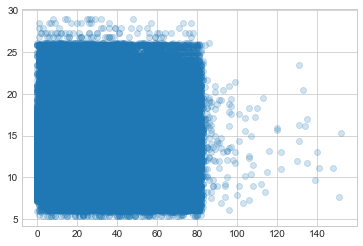

In [77]:

print (loan_check['mths_since_last_delinq'].describe())
# 이자율, 투자받은 금액과 관계가 있을까?


sns.set_style("whitegrid", )
X = loan_check['mths_since_last_delinq']
y = loan_col_real['int_rate']
plt.scatter(X, y, alpha=0.2)
plt.show()

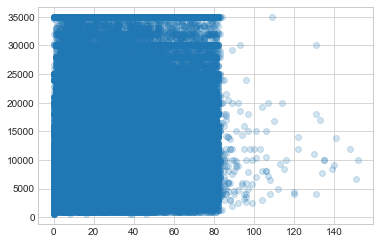

In [78]:
sns.set_style("whitegrid", )
X = loan_check['mths_since_last_delinq']
y = loan_col_real['loan_amnt']
plt.scatter(X, y, alpha = 0.2)
plt.show()

In [79]:
# 크게 영향을 미치지 않는 것 같다. 평균값으로 채운다
loan.mths_since_last_delinq.fillna(35.0, inplace = True)
print (loan.mths_since_last_delinq.isnull().value_counts())

False    270887
Name: mths_since_last_delinq, dtype: int64


In [80]:
loan.mths_since_last_delinq

0         35.0
1         35.0
2         35.0
3         35.0
5         35.0
7         35.0
8         35.0
9         35.0
10        35.0
11        35.0
12        35.0
13        35.0
14        35.0
15        35.0
16        61.0
17        35.0
18         8.0
19        35.0
20        35.0
21        35.0
22        35.0
23        35.0
24        35.0
25        35.0
26        35.0
27        20.0
28        18.0
29        35.0
30        35.0
31        35.0
          ... 
887198    62.0
887202    35.0
887215    35.0
887231    35.0
887248    41.0
887249    20.0
887254    35.0
887258    35.0
887263    35.0
887264    10.0
887268     6.0
887275    35.0
887276    35.0
887279    35.0
887280    35.0
887290    29.0
887303    11.0
887308    11.0
887322    28.0
887330    73.0
887332    35.0
887337     6.0
887345    69.0
887346    45.0
887347    35.0
887351    38.0
887364    16.0
887366    35.0
887369    35.0
887371    65.0
Name: mths_since_last_delinq, Length: 270887, dtype: float64

### (7) mths_since_last_record
* The number of months since the last public record.
* 공공 타기관에서 데이터를 가져오는 것이기 때문에 평균값이나 최빈값으로 채워넣는 것은 무의미하다고 생각한다

In [81]:

print (loan_check['mths_since_last_record'].describe())
# 이자율, 투자받은 금액과 관계가 있을까?

print (loan_check.mths_since_last_record.isnull().value_counts())
print (loan_check.mths_since_last_record.value_counts())

count    35077.000000
mean        74.237364
std         30.860748
min          0.000000
25%         54.000000
50%         77.000000
75%        101.000000
max        129.000000
Name: mths_since_last_record, dtype: float64
True     235810
False     35077
Name: mths_since_last_record, dtype: int64
0.0      1278
104.0     505
105.0     503
114.0     496
111.0     494
113.0     491
106.0     490
116.0     489
109.0     488
107.0     486
112.0     480
115.0     479
110.0     477
118.0     473
103.0     466
108.0     464
117.0     464
101.0     458
102.0     454
100.0     450
98.0      442
96.0      435
61.0      427
93.0      422
94.0      414
86.0      411
99.0      410
71.0      408
69.0      405
54.0      403
         ... 
27.0      126
26.0      106
23.0      104
25.0       99
21.0       85
22.0       77
24.0       76
18.0       72
20.0       72
15.0       68
19.0       64
17.0       61
12.0       60
16.0       54
14.0       51
13.0       51
11.0       47
7.0        44
8.0        43
9.0 

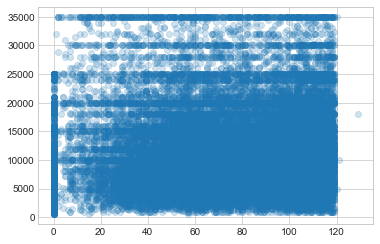

In [82]:
sns.set_style("whitegrid", )
X = loan_check['mths_since_last_record']
y = loan_col_real['loan_amnt']
plt.scatter(X, y, alpha=0.2)
plt.show()

In [83]:
# 해당 변수의 7/8정도가 null 이고 다른 변수간의 상관관계가 보이지 않기에 결손값은 0으로 채운다
loan.mths_since_last_record.fillna(0, inplace = True)
print (loan.mths_since_last_record.isnull().value_counts())

False    270887
Name: mths_since_last_record, dtype: int64


### (8) Mass null
* 200,000만개 이상(약75%이상)이 null인 변수는 값추정이 어려우므로 결손값을 0으로 채운다

In [84]:
col_null = ['next_pymnt_d','mths_since_last_major_derog','annual_inc_joint','dti_joint',
            'verification_status_joint','open_acc_6m','open_il_6m','open_il_12m',
            'open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',
            'open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m']                  


loan[col_null]= loan[col_null].fillna(0)


### (9)  open_acc &  pub_rec & total_acc & acc_now_delinq
<br>
현재 같은 수의 nan값임. 서로 유의미할까

* open_acc : 29
  <br>
  The number of open credit lines in the borrower's credit file.(현재 개설되어 있는 한도대출 개수)
* pub_rec : 29
   <br> Number of derogatory public records (공공기록 수 - 연체 기록과 반비례 : 좋은 기록인 것 같다)
* total_acc : 29
    <br>The total number of credit lines currently in the borrower's credit file (차주의 한도대출 개수)
* acc_now_delinq : 29
    <br>The number of accounts on which the borrower is now delinquent.(현재 연체중인 계좌개수)

In [85]:
loan_check_temp_null= loan_check.loc[loan_check['open_acc'].isnull()]
loan_check_temp_notnull= loan_check.loc[loan_check['open_acc'].notnull()]

temp = ['open_acc','pub_rec','total_acc','acc_now_delinq']
loan_check_temp_null[temp]

# 똑같은 차주에 대해 비어져 있다는 것을 알 수 있다

,open_acc,pub_rec,total_acc,acc_now_delinq


In [86]:
#결손값이 없는 value의 describe
print (loan_check_temp_notnull[temp].describe())

            open_acc        pub_rec      total_acc  acc_now_delinq
count  270887.000000  270858.000000  270887.000000   270858.000000
mean       10.975883       0.147203      25.020256        0.003397
std         4.928395       0.444558      11.796579        0.063288
min         0.000000       0.000000       0.000000        0.000000
25%         7.000000       0.000000      16.000000        0.000000
50%        10.000000       0.000000      23.000000        0.000000
75%        14.000000       0.000000      32.000000        0.000000
max        76.000000      15.000000     150.000000        5.000000


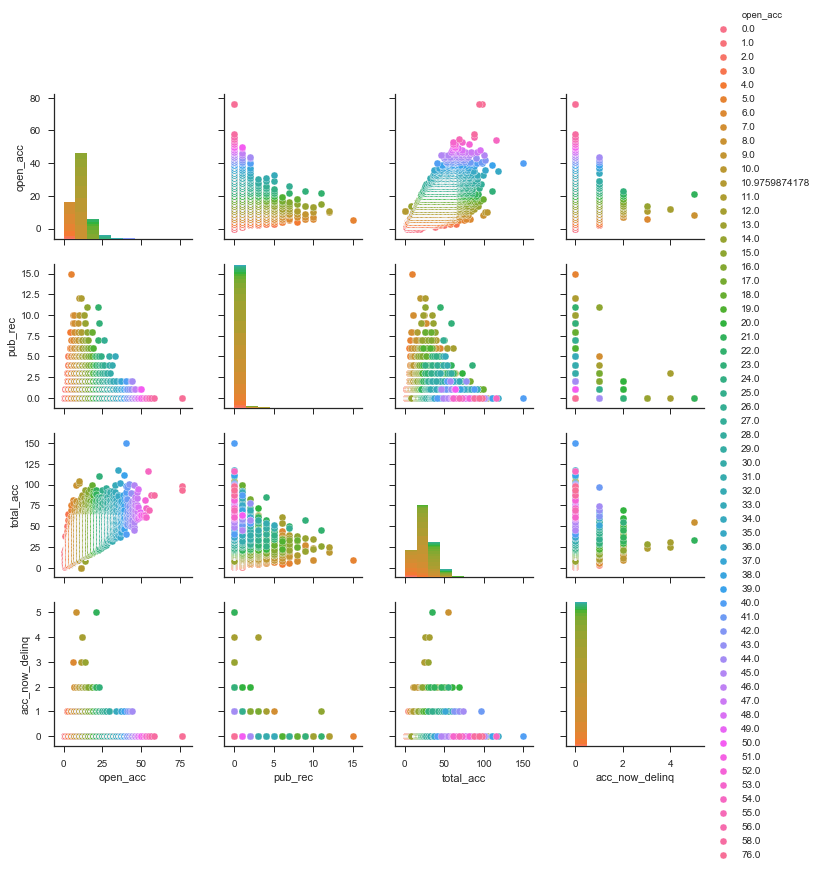

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True) #matplotlib에 기반한 시각화



sns.pairplot(data=loan_check_temp_notnull[temp],
             hue="open_acc", dropna=True)

plt.show()

In [87]:
#서로 관계는 있어 보이나, 같은 row의 값이 비어 있고, 전체 개수 중 미미한 개수인 것 같아 
# account=mean, 그 외는 0으로 처리한다

loan.open_acc.fillna(loan_check.open_acc.mean, inplace = True)
loan.total_acc.fillna(loan_check.total_acc .mean, inplace = True)
loan.pub_rec.fillna(0, inplace = True)
loan.acc_now_delinq.fillna(0, inplace = True)

loan.open_acc.isnull().value_counts()

False    270887
Name: open_acc, dtype: int64

In [88]:
# 메모리 정리
del loan_check_temp_null, loan_check_temp_notnull
gc.collect()

26783

###  (10) tot_coll_amt 
* Total collection amounts ever owed
* 다른 금액들간의 관계를 보자

In [89]:
temp = ['loan_amnt','funded_amnt','total_pymnt_inv','dti' ] # 대출, 혹은 투자받은 금액을 나태내는 변수들

X =pd.concat([loan_col_real[temp],loan_check['tot_coll_amt']],axis=1)
X = X.loc[X['tot_coll_amt'].notnull()] # na값이 아닌것만 뽑음
X.tail()


,loan_amnt,funded_amnt,total_pymnt_inv,dti,tot_coll_amt
887351,4200.0,4200.0,1026.02,36.93,0.0
887364,10775.0,10775.0,11071.87,13.22,0.0
887366,6225.0,6225.0,7050.46,18.58,0.0
887369,4000.0,4000.0,4158.02,12.63,0.0
887371,10850.0,10850.0,2396.05,29.44,972.0


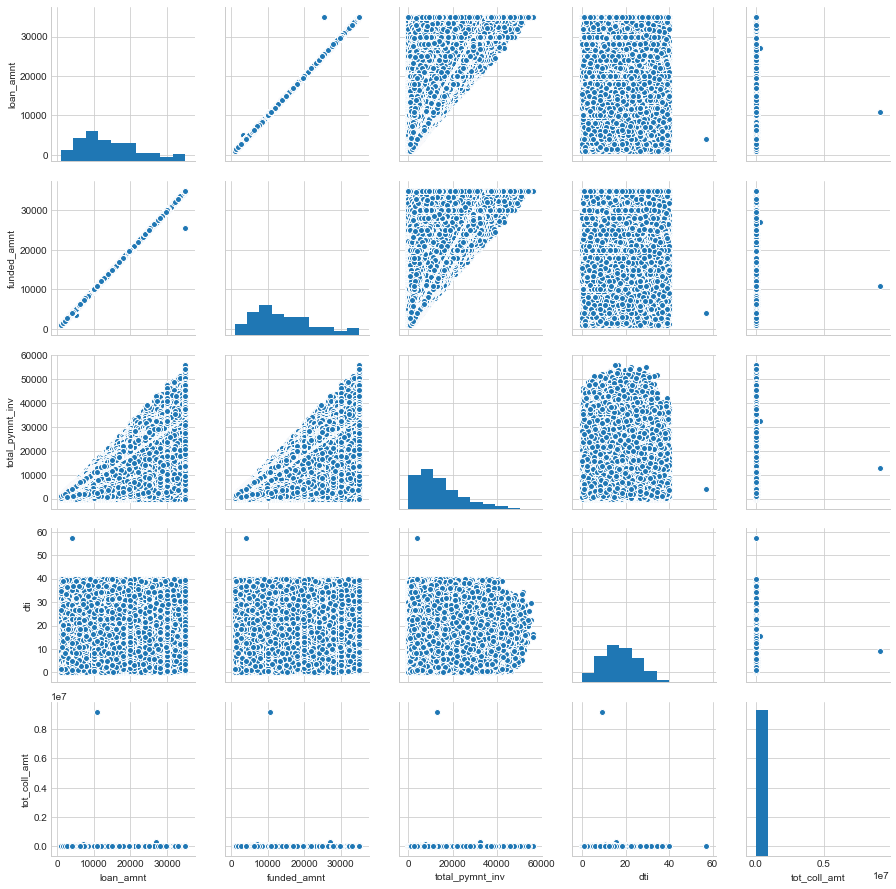

In [115]:
sns.pairplot(X)
plt.show()


In [90]:

print(X.tot_coll_amt.describe())
print('max value is : {}'.format(X.tot_coll_amt.max()))

# 1. tot_coll_amt는 대부분이 0이므로 다른 대출 규모와는 크게 상관이 없는 것 같다. 즉 결손값은 0으로 채울 것.
# 2. tot_coll_amt중 최대값을 나타내는 인자는 이상치인 것 같다. 추후 처리에 대해서 생각해야 함.
# 3. funded_amnt와 loan_amnt는 강력한 상관관계가 있는 것 같다

count    2.042640e+05
mean     2.050036e+02
std      2.031796e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
max value is : 9152545.0


In [91]:
loan.tot_coll_amt.fillna(0, inplace = True)

print (loan.tot_coll_amt.isnull().value_counts())

# 메모리 정리
del X
gc.collect()

False    270887
Name: tot_coll_amt, dtype: int64


143

### (11) collections_12_mths_ex_med   
* 보험 혹은 의료추심을 제외하고 12개월 이내의 추심 건수

In [72]:
print(loan_check.collections_12_mths_ex_med.describe())
print(loan_check.collections_12_mths_ex_med.value_counts())

count    270742.000000
mean          0.007332
std           0.093175
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: collections_12_mths_ex_med, dtype: float64
0.0    268909
1.0      1707
2.0       108
3.0        13
4.0         3
6.0         1
5.0         1
Name: collections_12_mths_ex_med, dtype: int64


In [73]:
# 결손값은 최빈값인 0으로 채운다
loan.collections_12_mths_ex_med.fillna(0, inplace = True)

print (loan.collections_12_mths_ex_med.isnull().value_counts())

False    270887
Name: collections_12_mths_ex_med, dtype: int64


### 중간점검

In [81]:
loan.apply(lambda x: sum(x.isnull()),axis=0) 

term                             0
grade                            0
sub_grade                        0
emp_title                        0
emp_length                       0
home_ownership                   0
verification_status              0
issue_d                          0
pymnt_plan                       0
purpose                          0
title                            0
zip_code                         0
addr_state                       0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
mths_since_last_delinq           0
mths_since_last_record           0
open_acc                         0
pub_rec                          0
revol_bal                        0
total_acc                        0
initial_list_status              0
out_prncp                        0
out_prncp_inv                    0
total_rec_late_fee               0
recoveries                       0
collection_recovery_fee          0
last_pymnt_d        

### (12) last_pymnt_d
* Last month payment was received
* 가장최근 상환한 달
* 대출받은 날로부터 차이가 크면 꾸준히 상환했을거라 가정, non값은 issue_d로 대체하는 방법도 생각 해 본다

In [74]:


loan['last_pymnt_d'].fillna(loan['issue_d'], inplace=True)


print (loan.last_pymnt_d.isnull().value_counts())


False    270887
Name: last_pymnt_d, dtype: int64


### (13) last_credit_pull_d  
* The most recent month LC pulled credit for this loan
* 가장 최근에 신용등급을 조회한 달

In [75]:
loan_check.last_credit_pull_d.tail()

270882    Jan-2016
270883    Jun-2015
270884    Dec-2015
270885    Nov-2015
270886    Jan-2016
Name: last_credit_pull_d, dtype: object

In [76]:
loan.last_pymnt_d.isnull().value_counts()

False    270887
Name: last_pymnt_d, dtype: int64

In [77]:
# last_pymnt_d 로 추정할 수 있을 것 같다

print(loan['last_credit_pull_d'].fillna(loan['last_pymnt_d'], inplace=True))

print (loan.last_credit_pull_d.isnull().value_counts())

None
False    270887
Name: last_credit_pull_d, dtype: int64


### (14)delinq_2yrs 
* The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
* 지난 2년간에 30일초과한 연체개수

In [78]:
print(loan_check.delinq_2yrs.describe())

count    270858.000000
mean          0.258552
std           0.759819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64


In [79]:
#평균은 1이 안되는데 비해 max값이 29임을 확인해서 최빈값인 0으로 결손값을 채운다

loan.delinq_2yrs.fillna(0, inplace = True)

print (loan.delinq_2yrs.isnull().value_counts())


False    270887
Name: delinq_2yrs, dtype: int64


### 결손값 최종확인


In [189]:
loan_check.apply(lambda x: sum(x.isnull()),axis=0) 

term                           0
grade                          0
sub_grade                      0
emp_title                      0
emp_length                     0
home_ownership                 0
verification_status            0
issue_d                        0
pymnt_plan                     0
purpose                        0
title                          0
zip_code                       0
addr_state                     0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
open_acc                       0
pub_rec                        0
revol_bal                      0
total_acc                      0
initial_list_status            0
out_prncp                      0
out_prncp_inv                  0
total_rec_late_fee             0
recoveries                     0
collection_recovery_fee        0
last_pymnt_d                   0
last_pymnt_amnt                0
next_pymnt

In [191]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [203]:
indexs=['id', 'member_id','loan_status', 'url', 'desc', 'purpose','mths_since_last_delinq',
       'mths_since_last_record',  'pub_rec',
        'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint']

In [204]:
X = loan[indexs]

In [205]:
X.apply(lambda x: sum(x.isnull()),axis=0) 

id                             0
member_id                      0
loan_status                    0
url                            0
desc                           0
purpose                        0
mths_since_last_delinq         0
mths_since_last_record         0
pub_rec                        0
initial_list_status            0
out_prncp                      0
out_prncp_inv                  0
total_pymnt                    0
total_pymnt_inv                0
total_rec_prncp                0
total_rec_int                  0
total_rec_late_fee             0
recoveries                     0
collection_recovery_fee        0
last_pymnt_d                   0
last_pymnt_amnt                0
next_pymnt_d                   0
last_credit_pull_d             0
collections_12_mths_ex_med     0
mths_since_last_major_derog    0
policy_code                    0
application_type               0
annual_inc_joint               0
dti_joint                      0
verification_status_joint      0
dtype: int

In [120]:
loan[col_real] = loan_col_real[col_real]

In [81]:

print (loan.desc.isnull().value_counts())

False    270887
Name: desc, dtype: int64


In [80]:
loan.desc.fillna(0, inplace = True)

print (loan.desc.isnull().value_counts())

False    270887
Name: desc, dtype: int64


In [129]:
loan.apply(lambda x: sum(x.isnull()),axis=0) 

id                             0
member_id                      0
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_title                      0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
issue_d                        0
loan_status                    0
pymnt_plan                     0
url                            0
desc                           0
purpose                        0
title                          0
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
          

# 4. 다음 처리를 위한 pickle변환 

In [82]:
import pickle

pickle.dump( loan, open( "loan_preprocess", "wb" ) )